In [1]:
import numpy as np
import os
import csv
import sys
import matplotlib.pyplot as plt
import colorcet as cc
import time
import multiprocessing
import random
from tabulate import tabulate
import itertools
import pickle
from collections import Counter
import seaborn as sns

## __SI:__ Antimicrobial resistance level and conjugation permissiveness shape plasmid distribution in clinical enterobacteria

###7. Computer experiments: Analyzing results of iterative knock-out simulations
This Jupyter Notebook focuses on the analysis and visualization of the data generated from the iterative knock-out simulations described in the previous notebook. The main goal here is to interpret the changes in plasmid stability within the community following the sequential removal of strains.

After the iterative removal process, we are left with the densities of the remaining strains and their corresponding plasmid-bearing fractions. By examining these data, we are able to identify which strains, when removed, had a significant impact on plasmid stability within the community. This information helps us recognize the strains that form successful associations with the plasmid, underlining their contribution to maintaining antibiotic resistance within the community.



### Experimental parameters

In [3]:
sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *
from pOXA48_S3 import *

%run src/pOXA48_parameters
print_expe_params(expe_params)



Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-10 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------


### Model parameters

In [4]:

model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)
display_model_params_stats(model_params, strains_subset)


╒═════════╤═════════════╤═══════════════════════╤═════════════════════════════════╤═════╕
│ Group   │ Parameter   │ Mean                  │ Range                           │ N   │
╞═════════╪═════════════╪═══════════════════════╪═════════════════════════════════╪═════╡
│ E-TC    │ conj_rate   │ nan                   │ (nan, nan)                      │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ VKm         │ 5.931e-10             │ (3.79e-10, 7.6e-10)             │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ rho         │ 948158352.0           │ (550386500.0, 1121715175.0)     │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ seg_rate    │ 0.0020000000000000005 │ (0.002, 0.002)                  │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    

### Experiment parameters

In [5]:
num_days = 10
num_experiments = 100

M_values=range(1,len(strains_subset)+1)
powers = np.arange(-4.0,20.0)  # array of powers of two exponents
Amax_values=np.power(2, powers)  # calculate 2 raised to each exponent
verbose=False


runPathN = path+'runs/N'+str(num_days)+'/'
print("runPath=%s"%runPathN)


runPath=./runs/N10/


In [6]:
def get_sequences_from_files(directory, length=None):
    """
    Extracts sequences of integers from the names of the files in a directory.

    This function looks for files with names that start with "sim_Es_" and end with ".pkl", then
    extracts a sequence of integers from the rest of the filename. It assumes that the integers
    are separated by underscores.

    Parameters:
    directory: str
        The path to the directory containing the files.
    length: int, optional
        The length of the sequences to look for. If specified, only sequences of this length are returned.
        If not specified, sequences of any length are returned.

    Returns:
    sequences: list of lists
        A list of the sequences that were found. Each sequence is represented as a list of integers.
    """
    sequences = []

    for filename in os.listdir(directory):
        if filename.startswith("sim_Es_") and filename.endswith(".pkl"):
            sequence = filename[len("sim_Es_"):-len(".pkl")]
            sequence = list(map(int, sequence.split('_')))

            if length is None or len(sequence) == length:
                sequences.append(sequence)

    return sequences


In [7]:
from datetime import datetime
import math

def get_update_simulations(runPathN, str_E, num_days, Amax_values, length=20):
    """
    Count the number of simulations performed for each drug concentration.

    This function looks in the directories corresponding to each drug concentration
    and counts the number of files that start with "sim_Es_" and end with ".pkl".

    Parameters:
    runPathN: str
        The path to the parent directory containing the drug concentration directories.
    str_E: str
        String representing the drug effect.
    num_days: int
        The number of days for which the simulations were run.
    Amax_values: list
        List of drug concentrations.
    length: int, optional
        The length of the sequences to count. Default is 20.

    Returns:
    counts: dict
        A dictionary where each key is a drug concentration and each value is a tuple.
        The first element of the tuple is the total number of simulations and the second element
        is the number of simulations that produced sequences of the specified length.
    """
    counts = {}

    for Amax in Amax_values:
        # Construct the path to the directory where the data is stored
        directory = '%s/%s_N%s_A%se-2/' % (runPathN, str_E, num_days, int(100*Amax))

        # Get the sequences from the files in the directory
        all_sequences = get_sequences_from_files(directory)
        length_sequences = get_sequences_from_files(directory, length=length)

        # Count the number of sequences
        counts[Amax] = (len(all_sequences), len(length_sequences))

    # Get the current date and time
    now = datetime.now()

    print(f"Number of simulations performed at {now.strftime('%Y-%m-%d %H:%M')}:\n")

    return counts

# Get the status of the simulations
status_simulations = get_update_simulations(runPathN, str_E, num_days, Amax_values)

df = pd.DataFrame.from_records(
    [(math.log2(Amax), total, length_20) for Amax, (total, length_20) in status_simulations.items()],
    columns=["Drug Concentration (log2)", "#Simulations", "#Completed"],
    index="Drug Concentration (log2)"
)
print(df)

Number of simulations performed at 2023-12-18 15:04:

                           #Simulations  #Completed
Drug Concentration (log2)                          
-4.0                               1918         100
-3.0                               1933         100
-2.0                               1910         100
-1.0                               1909         100
 0.0                               1923         100
 1.0                               1945         101
 2.0                               2860         151
 3.0                               2316         122
 4.0                               2595         137
 5.0                               2430         128
 6.0                               2438         128
 7.0                               2109         109
 8.0                               1915         100
 9.0                               1921         100
 10.0                              1907         100
 11.0                              2445         127
 12.0     

In [8]:

figPathN="%sN%s/"%(figPath, num_days)
if not os.path.exists(figPathN):
  os.makedirs(figPathN)

## Computer experiments

In [9]:
def load_simulation_results(filename):
    """
    Loads previously saved simulation results from a pickle file.

    Parameters:
    filename: str
        The name of the file from which to load the simulation results.

    Returns:
    tuple
        The simulation results loaded from the file, including istrains, Es, Btot, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params.
    """

    # Open the file in binary mode for reading
    with open(filename, "rb") as f:
        # Load the contents of the file using pickle
        results = pickle.load(f)

    # Return the contents of the file as a tuple of values
    return results["istrains"], results["Es"],  results["Btot"], results["BpEs"], results["BpKs"], results["BfEs"], results["BfKs"], results["freqpEs"], results["freqpKs"], results["ts"], results["ys"], results["params"]


In [10]:
def load_survival(M, Amax_values, verbose=False):
    """
    Load the simulation results and plot the survival rates as a function of drug concentration.

    Parameters:
    M: int
        The maximum number of strains.
    Amax_values: list
        List of drug concentrations.
    verbose: bool, optional
        If True, print verbose output. Default is False.
    """
    expe_Amaxs = []
    expe_survival = []

    for Amax in Amax_values:
        # Define the path to the files
        runPath = '%s%s_N%s_A%se-2/' % (runPathN, str_E, num_days, int(Amax*100))
        if not os.path.isdir(runPath):
            print(f"Directory {runPath} does not exist. Skipping.")
        else:

          # Get the sequences from the files
          expe_istrains = get_sequences_from_files(runPath, length=len(strains_subset))
          total_experiments = 0
          survived_experiments = 0

          for iexpe in range(np.min([num_experiments, len(expe_istrains)])):
              # Select M strains
              this_istrains = expe_istrains[iexpe][:M]

              # Create a string label for the simulation
              sim_lbl = "_".join(map(str, this_istrains))

              # Define the file path
              filePath = f"{runPath}sim_Es_{sim_lbl}.pkl"

              if os.path.isfile(filePath):
                  # Load the simulation results
                  this_subset, this_Es, this_Btot, this_BpEs, this_BpKs, this_BfEs, this_BfKs, this_freqpEs, this_freqpKs, this_ts, this_ys, this_params  = load_simulation_results(filePath)
                  if verbose:
                      print("%s: Loading %s" % (iexpe, filePath))
                  for j in range(len(this_Btot)):
                      # Calculate the survival rate
                      total_experiments += 1
                      if this_Btot[j][-1] > expe_params['extinction_threshold']:
                          survived_experiments += 1

              if total_experiments>0:
                expe_Amaxs.append(Amax)
                expe_survival.append(100.0*survived_experiments / total_experiments)


    # Plot the survival rates
    return expe_Amaxs, expe_survival


This plot shows the survival rate as a function of drug concentration for different community sizes. The size of the community (M) is encoded in color, with a colorbar providing a key for the colors.

A different line is plotted for each community size. For each line, the drug concentration (Amax) is plotted on the x-axis and the survival rate is plotted on the y-axis. This allows you to see how the survival rate changes as the drug concentration increases, and how this relationship differs for communities of different sizes.



In [11]:
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib.ticker as ticker


sim_path = "%ssurvival_Amax.pkl" % (runPathN)
survival_all=[]
Amax_all=[]
if not os.path.exists(sim_path):
  for M in M_values:
      print("M=%s"%M)
      expe_Amaxs, expe_survival = load_survival(M, Amax_values,verbose=False)
      survival_all.append(expe_survival)
      Amax_all.append(expe_Amaxs)

  data_to_save = {"survival_all": survival_all, "Amax_all": Amax_all}
  with open(sim_path, 'wb') as f:
    pickle.dump(data_to_save, f)
    print("\tSaving ", sim_path)

else:
  with open(sim_path, 'rb') as f:
    data_loaded = pickle.load(f)
  survival_all = data_loaded["survival_all"]
  Amax_all = data_loaded["Amax_all"]

We use the following code to visualize survival rates as a function of two parameters: community size (M) and drug concentration (Amax). The data for these parameters are provided as inputs to the function in the form of a survival rate matrix (survival_all), a list of lists for different drug concentrations (Amax_all), and a list of community sizes (M_values).

The function first creates a scatter plot with each point's x-coordinate corresponding to a community size and the y-coordinate corresponding to the logarithm base 2 of a drug concentration. The color of each point is determined by the survival rate associated with the given community size and drug concentration, represented as a percentage and visualized using a colormap ranging from 0% (blue) to 100% (yellow).

<ipython-input-12-f8f40f9511a5>:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Survival %')


Exporting ./figures/N10/survival_scatter.pdf


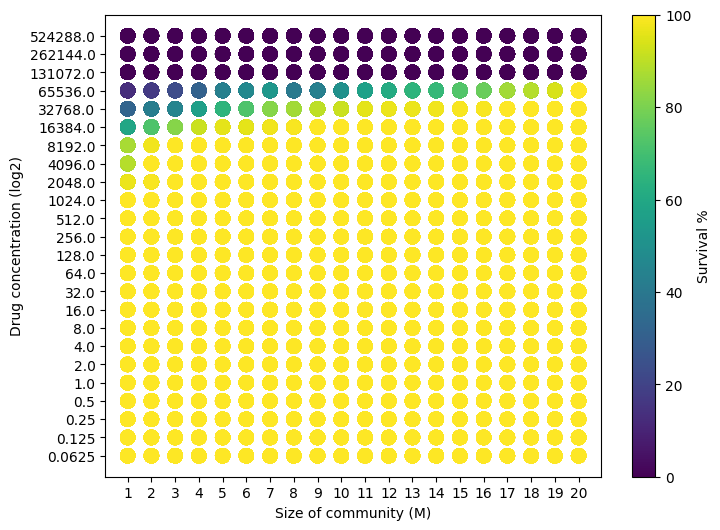

In [12]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_survival_scatter(survival_all, Amax_all, M_values):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a Normalize object for mapping color
    norm = Normalize(vmin=0, vmax=100)  # Assuming survival values are percentages (0-100)

    # Plot data points for each M value
    for M_val, survival_vals, Amax_vals in zip(M_values, survival_all, Amax_all):
        ax.scatter([M_val]*len(survival_vals), np.log2(Amax_vals), c=survival_vals, cmap='viridis', norm=norm, s=100)

    # Create a ScalarMappable object for creating the colorbar
    sm = ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # This line is necessary for the colorbar to appear

    # Add a colorbar
    plt.colorbar(sm, label='Survival %')

    # Get unique Amax values for y ticks
    flattened_Amax = [val for sublist in Amax_all for val in sublist]
    sorted_unique_Amax = sorted(list(set(flattened_Amax)))

    # Set axis labels and ticks
    ax.set_xlabel('Size of community (M)')
    ax.set_ylabel('Drug concentration (log2)')
    ax.set_yticks(np.log2(sorted_unique_Amax))
    ax.set_yticklabels(sorted_unique_Amax)
    ax.set_xticks(M_values)


    if not os.path.exists(figPathN):
        os.makedirs(figPathN)
    strain_path="%ssurvival_scatter.pdf"%(figPathN)
    print("Exporting %s"%strain_path)
    plt.savefig(strain_path)
    plt.show()

# Call the function
plot_survival_scatter(survival_all, Amax_all, M_values)


Exporting ./figures/N10/survival_ic50.pdf


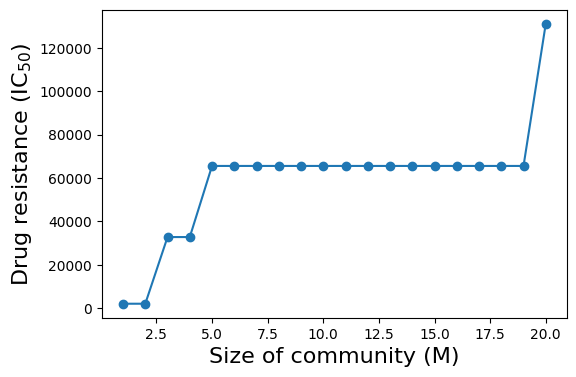

In [13]:
def plot_ic50(survival_all, Amax_all, M_values):
    # Initialize an empty list to store IC50 values
    IC50_values = []

    # For each column (M value), find the critical drug concentration (IC50)
    for i in range(len(M_values)):
        survival_column = survival_all[i]
        for j in range(len(Amax_all[i])):
            if survival_column[j] < 50:
                IC50_values.append(Amax_all[i][j])
                break
        else:
            # If no IC50 value found for a particular M, append NaN
            IC50_values.append(np.nan)

    # Plot M vs IC50
    plt.figure(figsize=(6, 4))
    plt.plot(M_values, IC50_values, marker='o')
    plt.xlabel('Size of community (M)',fontsize=16)
    plt.ylabel(r'Drug resistance (IC$_{50}$)',fontsize=16)
    plt.grid(False)

    if not os.path.exists(figPathN):
        os.makedirs(figPathN)
    strain_path="%ssurvival_ic50.pdf"%(figPathN)
    print("Exporting %s"%strain_path)
    plt.savefig(strain_path)
    plt.show()

plot_ic50(survival_all, Amax_all, M_values)


In [14]:


def load_PF_M(M_values, Amax, verbose=False):
    """
    Load and process simulation results from a directory.

    Parameters:
    M_values: list
        List of community sizes to consider.
    Amax: float
        The concentration of the drug for which the simulations were run.
    verbose: bool, optional
        If True, print additional information.

    Returns:
    final_expe: list
        List of indices of the experiments for each strain.
    final_M: list
        List of sizes of the community for each strain.
    final_pf: list
        List of final plasmid fractions for each strain.
    stabilizing_strains: list
        List of stabilizing strains.
    """

    final_pf=[]
    final_M=[]
    final_expe=[]
    stabilizing_strains=[]

    runPath = '%s%s_N%s_A%se-2/' % (runPathN, str_E, num_days, int(100*Amax))
    if not os.path.isdir(runPath):
        print(f"Directory {runPath} does not exist. Skipping.")
        return final_expe, final_M, final_pf, stabilizing_strains

    expe_istrains = get_sequences_from_files(runPath, length=len(strains_subset))

    for iexpe in range(np.min([num_experiments, len(expe_istrains)])):
        for this_istrains in [expe_istrains[iexpe]]:
            if verbose:
                print(this_istrains)

            unstable = [True]*len(expe_istrains)

            for M in M_values:
                M_istrains = this_istrains[:M]  # fix M value
                str_subset = [str(x) for x in M_istrains]  # Convert all elements to string
                sim_lbl = "_".join(str_subset)  # Join elements with "_"
                fileName = "sim_Es_%s.pkl" % sim_lbl  # Construct the filename
                filePath = "%s%s" % (runPath, fileName)
                if os.path.isfile(filePath):
                    this_subset, this_Es, this_Btot, this_BpEs, this_BpKs, this_BfEs, this_BfKs, this_freqpEs, this_freqpKs, this_ts, this_ys, this_params  = load_simulation_results(filePath)
                    if verbose:
                        print("%s: Loading %s" % (M, filePath))

                    for j in range(len(this_Btot)):
                        this_Bp = this_BpEs[j][-1] + this_BpKs[j][-1] # final Bp value
                        this_density = this_Btot[j][-1] # final total density

                        if this_density > expe_params['extinction_threshold']:
                            this_final_pf = this_Bp / this_density
                        else:
                            this_final_pf = np.nan

                        if verbose:
                            print('\t',this_Bp, ' / ', this_density, ' = ', np.round(100*this_final_pf),'%')
                        final_pf.append(this_final_pf)
                        final_M.append(M)
                        final_expe.append(iexpe)

                        if unstable[iexpe]==True:

                            if this_final_pf>0.5: #plasmid stable
                                if verbose:
                                  print("*** Stabilizing strain %s: %s"%(iexpe, M_istrains[-1]))
                                stabilizing_strains.append(M_istrains[-1])

                                unstable[iexpe]=False
                else:
                    if verbose:
                        print("Not found %s" % (filePath))
    return final_expe, final_M, final_pf, stabilizing_strains

def plot_M_v_PF(final_expe, final_M, final_pf):
    """
    Plot the final plasmid fraction against the size of the community for each experiment.

    Parameters:
    final_expe: list
        List of indices of the experiments for each strain.
    final_M: list
        List of sizes of the community for each strain.
    final_pf: list
        List of final plasmid fractions for each strain.

    Returns:
    None
    """

    # Get unique experiment indices
    unique_expe = list(set(final_expe))

    # Initialize plot
    plt.figure(figsize=(6, 4))  # Adjust the size as needed

    # Loop over unique experiment indices and plot each line separately
    for expe in unique_expe:
        # Get M and pf values for this experiment
        M_values = [final_M[i] for i in range(len(final_expe)) if final_expe[i] == expe]
        pf_values = [final_pf[i] for i in range(len(final_expe)) if final_expe[i] == expe]

        min_index = np.argmin(pf_values)  # get the index of the maximum value
        if np.min(pf_values) < 0.5 and np.max(pf_values[min_index:]) > 0.5:

          plt.plot(M_values, pf_values,'-', color='red', alpha=0.5) #, label=f"Experiment {expe}"
        else:
          plt.plot(M_values, pf_values, '-', color='grey', alpha=0.5)

    ax = plt.gca()  # Get current Axes instance
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    #plt.legend()
    plt.xlabel(r"Size of community ($M$)", fontsize=16)
    plt.ylabel("Final plasmid fraction", fontsize=16)
    #plt.gca().invert_xaxis()
    plt.ylim([-0.05, 1.05])

    if not os.path.exists(figPathN):
        os.makedirs(figPathN)
    strain_path="%sM_v_Pf.pdf"%(figPathN)
    print("Exporting %s"%strain_path)
    plt.savefig(strain_path)
    plt.show()


In [15]:
counts_score = []  # list to store final plasmid frequencies for all Amax values
counts_Amax = []
for Amax in Amax_values:
    final_expe, final_M, final_pf, stabilizing_strains, = load_PF_M(M_values, Amax, verbose=False)
    final_score=[]

    #plot_M_v_PF(final_expe, final_M, final_pf)

    count_stabilizing_strains = Counter(stabilizing_strains)
    print("Stabilizing strains (Amax=%s):"%Amax)
    for element, count in count_stabilizing_strains.most_common():
        print(f"\t[{element}] {strain_names[element]}: {count}")

    counts_Amax.append(count_stabilizing_strains)
    counts_score.append(list(final_score))


Stabilizing strains (Amax=0.0625):
	[38] PF_KPN11: 14
	[15] PF_EC16: 12
	[2] PF_EC03: 5
	[20] PF_EC21: 4
	[29] PF_KQ01: 1
Stabilizing strains (Amax=0.125):
	[15] PF_EC16: 10
	[38] PF_KPN11: 10
	[20] PF_EC21: 4
	[2] PF_EC03: 2
	[25] PF_KPN01: 1
Stabilizing strains (Amax=0.25):
	[15] PF_EC16: 13
	[38] PF_KPN11: 6
	[2] PF_EC03: 4
	[20] PF_EC21: 3
	[37] PF_KPN10: 1
	[43] PF_KPN14: 1
Stabilizing strains (Amax=0.5):
	[38] PF_KPN11: 12
	[15] PF_EC16: 7
	[20] PF_EC21: 7
	[2] PF_EC03: 6
	[45] PF_KPN16: 1
	[25] PF_KPN01: 1
Stabilizing strains (Amax=1.0):
	[2] PF_EC03: 17
	[38] PF_KPN11: 11
	[15] PF_EC16: 9
	[20] PF_EC21: 6
	[29] PF_KQ01: 2
	[25] PF_KPN01: 1
Stabilizing strains (Amax=2.0):
	[2] PF_EC03: 12
	[38] PF_KPN11: 8
	[15] PF_EC16: 7
	[20] PF_EC21: 7
	[45] PF_KPN16: 7
	[25] PF_KPN01: 4
Stabilizing strains (Amax=4.0):
	[2] PF_EC03: 28
	[15] PF_EC16: 8
	[20] PF_EC21: 7
	[45] PF_KPN16: 6
	[38] PF_KPN11: 4
	[25] PF_KPN01: 4
	[18] PF_EC19: 1
Stabilizing strains (Amax=8.0):
	[2] PF_EC03: 17
	[38

In [16]:
def create_stabilizing_matrix(strains, counts_Amax):
    """
    Create a matrix representing the number of times each strain stabilized the community, for each Amax value.

    Parameters:
    strains: list
        List of different bacterial strains.
    counts_Amax: list of dictionaries
        Each dictionary contains the counts of stabilizing strains for a certain Amax value.
        The keys of the dictionary are strain indices and the values are the counts.

    Returns:
    matrix: np.ndarray
        A 2D array where each row corresponds to a strain and each column corresponds to an Amax value.
        The entry at each position (i, j) in the matrix is the number of times strain i was a stabilizing
        strain for Amax value j.
    """
    # Initialize an empty matrix with dimensions (number_of_strains x number_of_Amax_values)
    matrix = np.zeros((len(strains), len(counts_Amax)))

    # Loop over each Amax value
    for i, count in enumerate(counts_Amax):
        # Loop over each strain
        for j, strain in enumerate(strains):
            # If the strain was a stabilizing strain for this Amax value, store the count in the matrix
            if j in count:
                matrix[j, i] = count[j]

    return matrix

stability_matrix = create_stabilizing_matrix(strains, counts_Amax)


In [17]:
print(len(stability_matrix))

50


Exporting ./figures/N10/stabilizing_heatmap.pdf


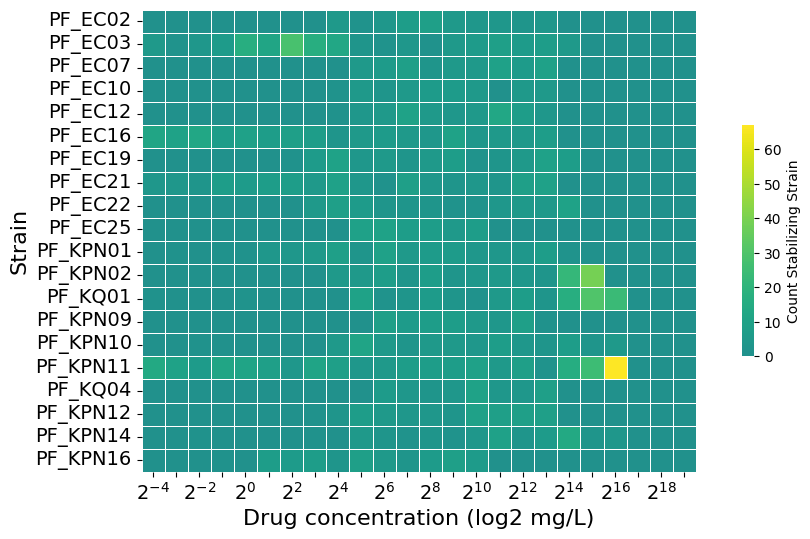

In [18]:
def plot_stabilizing_heatmap(model_params, strains_subset, stabilizing_matrix):
    """
    Plot a heatmap representing the frequency of each strain being stabilizing for different drug concentrations.

    Parameters:
    model_params: dict
        Dictionary containing model parameters, including 'strain_name' mapping strain indices to names.
    strains_subset: list
        List of strain indices that we're interested in.
    stabilizing_matrix: np.ndarray
        Matrix with the number of times each strain was stabilizing for each drug concentration.

    Returns:
    None
    """
    # Subset the stabilizing matrix to only include rows in the strains_subset
    stabilizing_matrix_subset = stabilizing_matrix[strains_subset, :]

    # Map strain indices to names for labeling
    strains_name = [model_params['strain_name'][i] for i in strains_subset]

    # Check if the subset is empty
    if stabilizing_matrix_subset.size == 0:
        print("The subset is empty.")
        return

    # Convert the stabilizing matrix to a DataFrame and normalize it by the maximum value
    stabilizing_df = pd.DataFrame(stabilizing_matrix_subset, index=strains_subset)
    max_value = stabilizing_df.values.max()  # find the maximum value in the DataFrame
    stabilizing_df /= 1 #max_value

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 6))

    # Draw the heatmap with the mask and correct aspect ratio
    cbar_kws = {"shrink": .5, 'label': 'Count Stabilizing Strain'}
    sns.heatmap(stabilizing_df, cmap="viridis", vmax=max_value, center=0,
                square=True, linewidths=.5, cbar_kws=cbar_kws)

    # Set y-axis labels
    ax.set_yticks(np.arange(stabilizing_df.shape[0])+0.5, minor=False)
    ax.set_yticklabels(strains_name, minor=False)
    plt.yticks(rotation=0)
    ax.set_ylabel('Strain', fontsize=16)

    # Set x-axis labels with log2 scale
    ax.set_xticks(np.arange(stabilizing_df.shape[1])+0.5, minor=False)
    ax.set_xlabel('Drug concentration (log2 mg/L)', fontsize=16)
    num_columns = stabilizing_df.shape[1]
    xticklabels = [r"$2^{" + f"{int(x)}" + r"}$" if x % 2 == 0 else '' for x in powers]
    ax.set_xticklabels(xticklabels)

    # Set fontsize for the tick parameters
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)


    if not os.path.exists(figPathN):
        os.makedirs(figPathN)
    strain_path="%sstabilizing_heatmap.pdf"%(figPathN)
    print("Exporting %s"%strain_path)
    plt.savefig(strain_path)

    # Display the plot
    plt.show()

# Call the function with model_params, strains_subset and stability_matrix
plot_stabilizing_heatmap(model_params, strains_subset, stability_matrix)


Exporting ./figures/N10/sim_stabilizing_low_N10.pdf


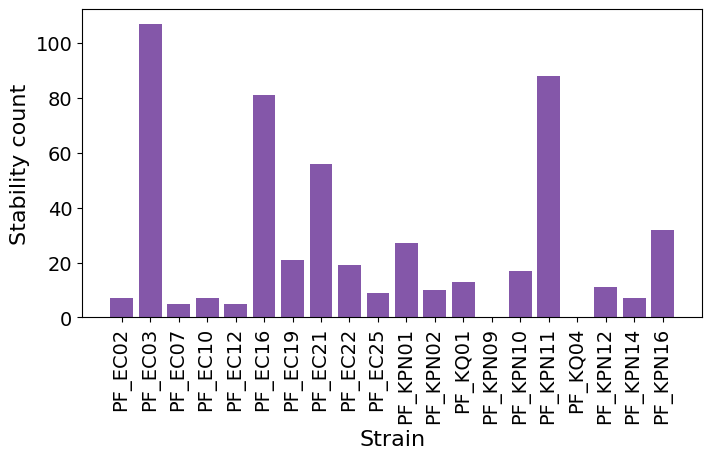

Exporting ./figures/N10/sim_stabilizing_high_N10.pdf


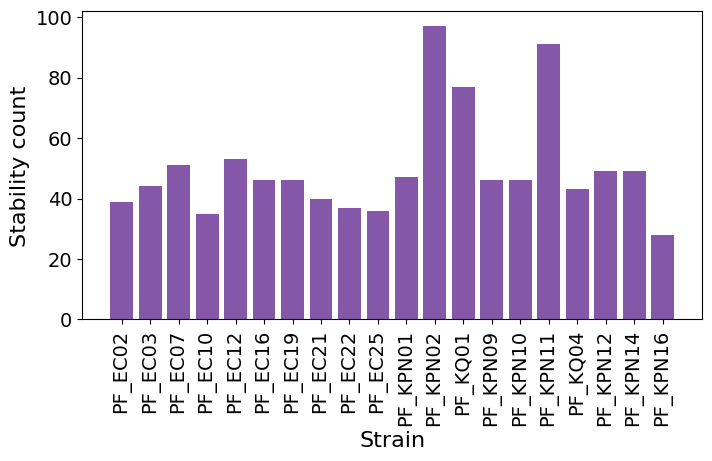

In [19]:
def plot_stabilizing_barchart(model_params, strains_subset, stabilizing_matrix, drug_concentration_range, plot_path=False):
    """
    Plot a bar chart representing the sum of frequencies of each strain being stabilizing for a range of drug concentrations.

    Parameters:
    model_params: dict
        Dictionary containing model parameters, including 'strain_name' mapping strain indices to names.
    strains_subset: list
        List of strain indices that we're interested in.
    stabilizing_matrix: np.ndarray
        Matrix with the number of times each strain was stabilizing for each drug concentration.
    drug_concentration_range: range
        Range of indices for the drug concentrations in the stabilizing matrix.

    Returns:
    None
    """
    # Subset the stabilizing matrix to only include rows in the strains_subset
    # and columns in the drug_concentration_range
    stabilizing_matrix_subset = stabilizing_matrix[strains_subset, :][:, drug_concentration_range]

    # Sum the frequencies across the specified drug concentrations
    stabilizing_array_subset = stabilizing_matrix_subset.sum(axis=1)

    # Map strain indices to names for labeling
    strains_name = [model_params['strain_name'][i] for i in strains_subset]

    # Check if the subset is empty
    if stabilizing_array_subset.size == 0:
        print("The subset is empty.")
        return

    # Convert the stabilizing array to a DataFrame and normalize it by the maximum value
    stabilizing_df = pd.DataFrame(stabilizing_array_subset, index=strains_subset)
    max_value = stabilizing_df.values.max()  # find the maximum value in the DataFrame
    stabilizing_df /= 1 #max_value

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 4))

    # Draw the bar chart
    ax.bar(strains_name, stabilizing_df[0], color='#8457A9')

    # Set labels
    ax.set_ylabel('Stability count', fontsize=16)
    ax.set_xlabel('Strain', fontsize=16)

    # Set fontsize for the tick parameters
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14, rotation=90)

    # Display the plot
    if plot_path:
      print("Exporting %s"%plot_path)
      plt.savefig(plot_path)

    plt.show()

# Call the function with model_params, strains_subset, stability_matrix and drug_concentration_range

plot_path_low="%ssim_stabilizing_low_N%s.pdf"%(figPathN, num_days)
plot_stabilizing_barchart(model_params, strains_subset, stability_matrix, range(0, 10), plot_path_low)

plot_path_high="%ssim_stabilizing_high_N%s.pdf"%(figPathN, num_days)
plot_stabilizing_barchart(model_params, strains_subset, stability_matrix, range(10, 20), plot_path_high)


In [20]:
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler

def plot_growthParams(model_params, strains_subset, drug_concentration_range, stability_matrix, ax):
    """
    Plot the growth parameters (resource conversion rate and specific affinity) of different strains.

    Parameters:
    model_params: dict
        A dictionary of parameters of the model.
    strains_subset: list
        List of strains to be included in the plot.
    drug_concentration_range: range
        Range of indices for the drug concentrations in the stability matrix.
    stability_matrix: np.ndarray
        A matrix that represents the number of times each strain was a stabilizer at different drug concentrations.
    ax: matplotlib.axes.Axes
        The axes on which to plot.

    Returns:
    None
    """
    VKm_values = model_params['VKm']
    rho_values = model_params['rho']

    # Subset the stability_matrix to include only rows in the strains_subset and columns in the drug_concentration_range
    stability_matrix_subset = stability_matrix[strains_subset, :][:, drug_concentration_range]

    # Sum the frequencies across the specified drug concentrations
    stability_counts = stability_matrix_subset.sum(axis=1)

    # Define the markers for each specie
    markers = {'E': 'o', 'K': 'o'}
    marker_colors = {'E': 'red', 'K': 'blue'}

    # Iterate over each strain and plot it with the corresponding color and marker
    for i, istrain in enumerate(strains_subset):
        ax.scatter(rho_values[istrain], VKm_values[istrain], s=stability_counts[i],
                   marker=markers[model_params['specie'][istrain]],
                   color=marker_colors[model_params['specie'][istrain]], label=model_params['specie'][istrain], alpha=0.5)

    ax.set_xlabel(r'Resource conversion rate ($\rho$)', fontsize=16)
    ax.set_ylabel(r'Specific affinity ($V_{\mathrm{max}}/Km$)', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Create custom handles for the legend
    handles = [Line2D([0], [0], marker='o', color='none', label='Ec', markerfacecolor='red', markersize=10),
               Line2D([0], [0], marker='o', color='none', label='Kpn', markerfacecolor='blue', markersize=10)]
    ax.legend(handles=handles)


The function plot_growthParams plots the growth parameters of different bacterial strains. It maps the resource conversion rate (rho) and the specific affinity (V_{\mathrm{max}}/Km) of each strain onto the x and y axes of the plot respectively.

Each circle in the plot represents a bacterial strain. The size of each point corresponds to the score of the strain (i.e., the number of times the strain had stabilized a population at a particular drug concentration). The color of each circle represents the species of the strain, with red for Ec and blue for Kpn.

In [21]:
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler

def plot_growthParams(model_params, strains_subset, drug_concentration_range, stability_matrix, ax):
    """
    Plot the growth parameters (resource conversion rate and specific affinity) of different strains.

    Parameters:
    model_params: dict
        A dictionary of parameters of the model.
    strains_subset: list
        List of strains to be included in the plot.
    drug_concentration_range: range
        Range of indices for the drug concentrations in the stability matrix.
    stability_matrix: np.ndarray
        A matrix that represents the number of times each strain was a stabilizer at different drug concentrations.
    ax: matplotlib.axes.Axes
        The axes on which to plot.

    Returns:
    None
    """
    VKm_values = model_params['VKm']
    rho_values = model_params['rho']

    # Subset the stability_matrix to include only rows in the strains_subset and columns in the drug_concentration_range
    stability_matrix_subset = stability_matrix[strains_subset, :][:, drug_concentration_range]

    # Sum the frequencies across the specified drug concentrations
    scale_factor=10
    stability_counts = stability_matrix_subset.sum(axis=1)*scale_factor

    # Define the markers for each specie
    markers = {'E': 'o', 'K': 'o'}
    marker_colors = {'E': 'red', 'K': 'blue'}

    # Iterate over each strain and plot it with the corresponding color and marker
    for i, istrain in enumerate(strains_subset):
        ax.scatter(rho_values[istrain], VKm_values[istrain], s=stability_counts[i],
                   marker=markers[model_params['specie'][istrain]],
                   color=marker_colors[model_params['specie'][istrain]], label=model_params['specie'][istrain], alpha=0.5)

    ax.set_xlabel(r'Resource conversion rate ($\rho$)', fontsize=16)
    ax.set_ylabel(r'Specific affinity ($V_{\mathrm{max}}/Km$)', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Create custom handles for the legend
    handles = [Line2D([0], [0], marker='o', color='none', label='Ec', markerfacecolor='red', markersize=10),
               Line2D([0], [0], marker='o', color='none', label='Kpn', markerfacecolor='blue', markersize=10)]
    ax.legend(handles=handles)


This function plots the conjugation rate and the resistance level (\kappa) of each strain on the x and y axes of the plot, respectively. Each point in the plot represents a bacterial strain. The size of each point corresponds to the score of the strain (i.e., the number of times the strain had a plasmid fraction greater than 0.2 at a particular drug concentration), with higher scores leading to larger points. The color of each point represents the species of the strain, with red for 'Ec' and blue for 'Kpn'.

In [22]:
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import ScalarFormatter, LogLocator

def plot_conjParams(model_params, strains_subset, drug_concentration_range, score_matrix, ax):
    """
    Plot the conjugation parameters (conjugation rate and resistance level) of different strains.

    Parameters:
    model_params: dict
        A dictionary of parameters of the model.
    strains_subset: list
        List of strains to be included in the plot.
    drug_concentration_range: range
        Range of indices for the drug concentrations in the score matrix.
    score_matrix: np.ndarray
        A matrix that represents the score for each strain at different drug concentrations.
    ax: matplotlib.axes.Axes
        The axes on which to plot.

    Returns:
    None
    """

    kappa_values = model_params['kappa']
    conj_rate_values = np.nan_to_num(model_params['conj_rate'], nan=-12)  # replace nan values with a very small positive number

    # Subset the score_matrix to include only rows in the strains_subset and columns in the drug_concentration_range
    score_matrix_subset = score_matrix[strains_subset, :][:, drug_concentration_range]

    # Sum the scores across the specified drug concentrations
    scale_factor=10
    score_counts = score_matrix_subset.sum(axis=1)*scale_factor

    # Define the markers for each specie
    markers = {'E': 'o', 'K': 'o'}
    marker_colors = {'E': 'red', 'K': 'blue'}

    # Iterate over each strain and plot it with the corresponding color and marker
    for i, istrain in enumerate(strains_subset):
        ax.scatter(10**conj_rate_values[istrain+tot_strains], kappa_values[istrain], s=score_counts[i],
                   marker=markers[model_params['specie'][istrain]],
                   color=marker_colors[model_params['specie'][istrain]], label=model_params['specie'][istrain], alpha=0.5)

    ax.set_xlabel(r'Conjugation rate', fontsize=16)
    ax.set_ylabel(r'Resistance level ($\kappa$)', fontsize=16)
    ax.set_ylim([2**-9, 2**0])

    ax.set_xscale('log', base=10)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlim([1e-12, 1e-9])
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9])
    ax.set_xticklabels(['0', '1e-11', '1e-10', '1e-9'])

    ax.set_yscale('log', base=2)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    handles = [Line2D([0], [0], marker='o', color='none', label='Ec', markerfacecolor='red', markersize=10),
               Line2D([0], [0], marker='o', color='none', label='Kpn', markerfacecolor='blue', markersize=10)]
    ax.legend(handles=handles)


Exporting ./figures/N10/params_stability_low.pdf


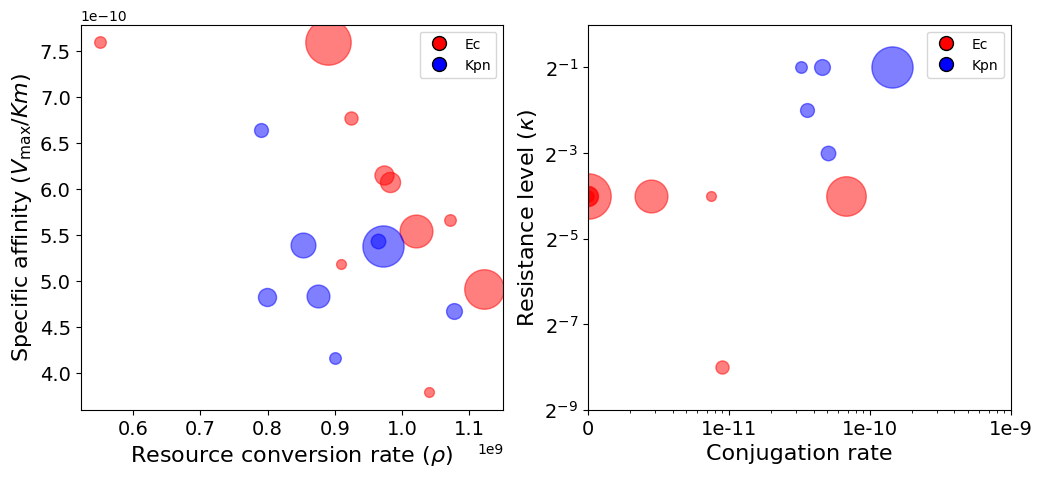

In [23]:

f, axs = plt.subplots(1,2, figsize=(12, 5))
plot_growthParams(model_params, strains_subset, range(0,10), stability_matrix, axs[0])
plot_conjParams(model_params,  strains_subset, range(0,10), stability_matrix, axs[1])


strain_path="%sparams_stability_low.pdf"%(figPathN)
print("Exporting %s"%strain_path)
plt.savefig(strain_path)
plt.show()

Exporting ./figures/N10/params_stability_high.pdf


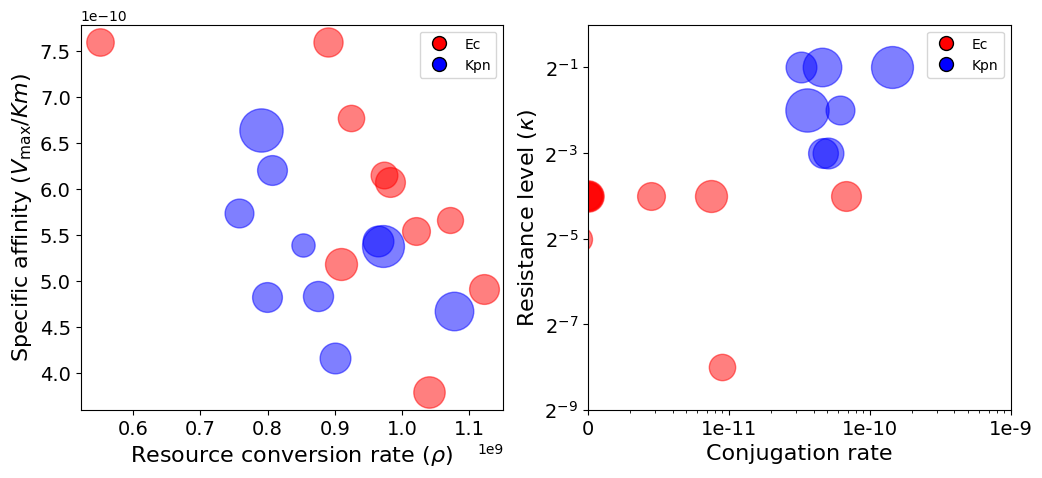

In [24]:

f, axs = plt.subplots(1,2, figsize=(12, 5))
plot_growthParams(model_params, strains_subset, range(10,20), stability_matrix, axs[0])
plot_conjParams(model_params,  strains_subset, range(10,20), stability_matrix, axs[1])

strain_path="%sparams_stability_high.pdf"%(figPathN)
print("Exporting %s"%strain_path)
plt.savefig(strain_path)
plt.show()